In [ ]:
#|default_exp 3c_experiments
#|hide
## Standard libraries
import os
import math
import numpy as np
import time
# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

## project specifics
import diffusion_curvature
from diffusion_curvature.datasets import *
from diffusion_curvature.graphs import *
from diffusion_curvature.core import *
import jax
import jax.numpy as jnp
jax.devices()

%load_ext autoreload
%autoreload 2

# 3c Sampling Experiments on Diffusion Curvature

## Dimensional Analysis of Planes

How does it perform with planes of varying dimensions?

Using clustering within the manifold:

In [ ]:
ds = [3,4,5,6]
planes = [plane(1000*2**(d-2), d) for d in ds]
for i, d in enumerate(ds):
    G = get_alpha_decay_graph(planes[i], decay=None, knn=15, anisotropy=1, )
    DC = DiffusionCurvature(laziness_method="Entropic",points_per_cluster=500,comparison_space_size_factor=1,comparison_method="Subtraction", flattening_method="Fixed")
    ks = DC.curvature(G, t=8, dim=d, knn=15)
    print("dimension",d,": Curvature of Plane is ",ks[0])

  0%|          | 0/4 [00:00<?, ?it/s]

dimension 3 : Curvature of Plane is  0.22488499


  0%|          | 0/8 [00:00<?, ?it/s]

dimension 4 : Curvature of Plane is  -0.0021333694


  0%|          | 0/16 [00:00<?, ?it/s]

dimension 5 : Curvature of Plane is  -0.1174202


  0%|          | 0/32 [00:00<?, ?it/s]

dimension 6 : Curvature of Plane is  -0.098750114


Without clustering

In [ ]:
ds = [3,4,5,6]
planes = [plane(1000*2**(d-2), d) for d in ds]
for i, d in enumerate(ds):
    G = get_alpha_decay_graph(planes[i], decay=None, knn=15, anisotropy=1, )
    DC = DiffusionCurvature(laziness_method="Entropic",points_per_cluster=None,comparison_space_size_factor=1,comparison_method="Subtraction", flattening_method="Fixed")
    ks = DC.curvature(G, t=8, dim=d, knn=15)
    print("dimension",d,": Curvature of Plane is ",ks[0])

  0%|          | 0/1 [00:00<?, ?it/s]

dimension 3 : Curvature of Plane is  -0.113577366


  0%|          | 0/1 [00:00<?, ?it/s]

dimension 4 : Curvature of Plane is  -0.031496525


  0%|          | 0/1 [00:00<?, ?it/s]

dimension 5 : Curvature of Plane is  -0.05647278


  0%|          | 0/1 [00:00<?, ?it/s]

dimension 6 : Curvature of Plane is  0.07413292


**Conclusion**: when using more points, there's less variance between dimensions — though still a slightly alarming amount of variance within them. There doesn't appear to be any pervasive bias induced by dimensionality in either setting. That said, this is the *best possible* condition, as it is literally comparing a plane to a plane.

## Planes under different sampling

In [ ]:
sampled_plane_ks = []
t = 8
for i in trange(1000):
    X_plane = plane(1000,2)
    G = get_alpha_decay_graph(X_plane, decay=None, knn=15, anisotropy=1, )
    DC = DiffusionCurvature(laziness_method="Entropic",points_per_cluster=None,comparison_space_size_factor=1,comparison_method="Subtraction", flattening_method="Fixed")
    ks = DC.curvature(G, t=t, dim=2, knn=15)
    sampled_plane_ks.append(ks[0])

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Ks of Plane, with No Clustering, Subtraction, t=8')

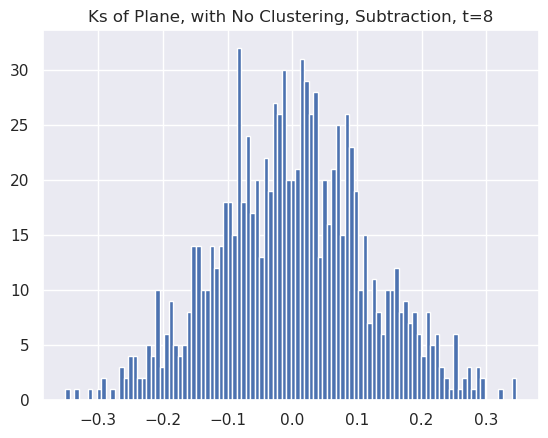

In [ ]:
# plot a histogram of the curvature values
plt.hist(sampled_plane_ks, bins=100)
plt.title(f"Ks of Plane, with No Clustering, Subtraction, t={t}")

That's not looking very good. The randomness of the plane sampling, combined with the randomness of the comparison space has created a lot of variability.

I see two strategies to address this: using a higher $t$, and comparing to a grid.

In [ ]:
sampled_plane_ks = []
t = 8
for i in trange(1000):
    X_plane = plane(1000,2)
    G = get_alpha_decay_graph(X_plane, decay=None, knn=15, anisotropy=1, )
    DC = DiffusionCurvature(laziness_method="Entropic",points_per_cluster=None,comparison_space_size_factor=1,comparison_method="Subtraction", flattening_method="Fixed", use_grid=True)
    ks = DC.curvature(G, t=t, dim=2, knn=15)
    sampled_plane_ks.append(ks[0])

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Ks of Plane, with Grid, No Clustering, Subtraction, t=8')

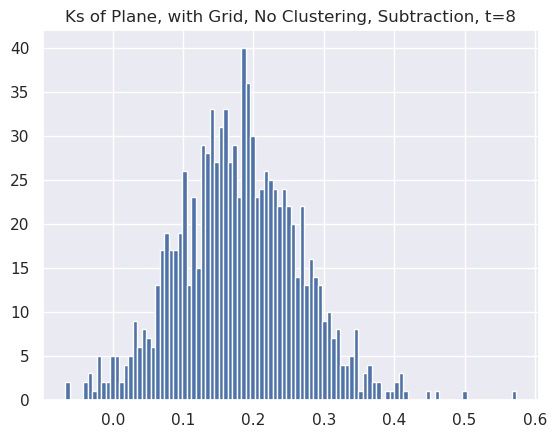

In [ ]:
# plot a histogram of the curvature values
plt.hist(sampled_plane_ks, bins=100)
plt.title(f"Ks of Plane, with Grid, No Clustering, Subtraction, t={t}")

Now this is odd. It appears the grid *biases* the results; it must have a higher-than-normal entropy, making everything appear more positive while it, the comparison, looks falsely negative. *What's up with this?*

On a more positive note, using a grid did shave off 0.2 variance.


Hypothesis 1: It's the kernel we're using. That darn alpha-decay kernel is somehow changing the shape of the grid. Disabling the decay should remedy the problem. To be doubly sure that's working, I can construct a kernel with my code.

1. Decay=None does nothing -- that's what we were using before.
2. But perhaps it has to do with the knn value! In a grid, the 15th nearest neighbor may be further than it is on a uniformly sampled surface, because the points are arranged in squares rather than circles.

In [ ]:
sampled_plane_ks = []
t = 8
for i in trange(1000):
    X_plane = plane(1000,2)
    G = get_alpha_decay_graph(X_plane, decay=None, knn=10, anisotropy=1, )
    DC = DiffusionCurvature(laziness_method="Entropic",points_per_cluster=None,comparison_space_size_factor=1,comparison_method="Subtraction", flattening_method="Fixed", use_grid=True)
    ks = DC.curvature(G, t=t, dim=2, knn=10)
    sampled_plane_ks.append(ks[0])

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Ks of Plane, with Grid, No Clustering, Subtraction, t=8, knn=10')

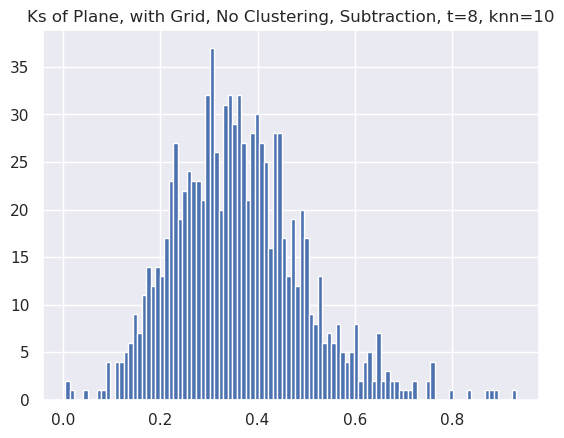

In [ ]:
# plot a histogram of the curvature values
plt.hist(sampled_plane_ks, bins=100)
plt.title(f"Ks of Plane, with Grid, No Clustering, Subtraction, t={t}, knn=10")

Support for the knn hypothesis. Changing k from 15 to 10 increased the perceived negativity of the grid's curvature.

This would likely be best avoided by *not* using a knn grid; or using some average of distances, rather than the concrete *distance from the kth* nearest neighbor.

It would also, if the hypothesis is shrewd, diminish in effect the higher the k.

In [ ]:
sampled_plane_ks = []
t = 8
for i in trange(1000):
    X_plane = plane(1000,2)
    G = get_alpha_decay_graph(X_plane, decay=None, knn=30, anisotropy=1, )
    DC = DiffusionCurvature(laziness_method="Entropic",points_per_cluster=None,comparison_space_size_factor=1,comparison_method="Subtraction", flattening_method="Fixed", use_grid=True)
    ks = DC.curvature(G, t=t, dim=2, knn=30)
    sampled_plane_ks.append(ks[0])

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Ks of Plane, with Grid, No Clustering, Subtraction, t=8, knn=30')

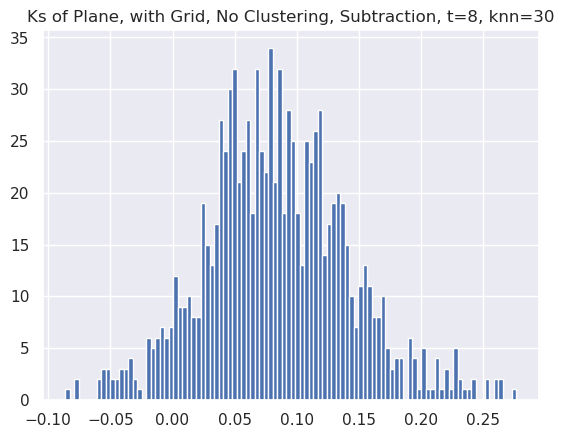

In [ ]:
# plot a histogram of the curvature values
plt.hist(sampled_plane_ks, bins=100)
plt.title(f"Ks of Plane, with Grid, No Clustering, Subtraction, t={t}, knn=30")

Indeed, using a larger knn value decreased the descrepency considerably. *But it's still there!*

As an ablation, here's this same experiment on a 5000 point plane.

Here's the k=15 version:
(With GPU, it jumps to about 10 minutes to run 1000 trials. Not bad. Thank ya, Nvidia!)

In [ ]:
sampled_plane_ks = []
t = 8
for i in trange(1000):
    X_plane = plane(5000,2)
    G = get_alpha_decay_graph(X_plane, decay=None, knn=15, anisotropy=1, )
    DC = DiffusionCurvature(laziness_method="Entropic",points_per_cluster=None,comparison_space_size_factor=1,comparison_method="Subtraction", flattening_method="Fixed", use_grid=True)
    ks = DC.curvature(G, t=t, dim=2, knn=15)
    sampled_plane_ks.append(ks[0])

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Ks of Plane, with Grid, No Clustering, Subtraction, t=8')

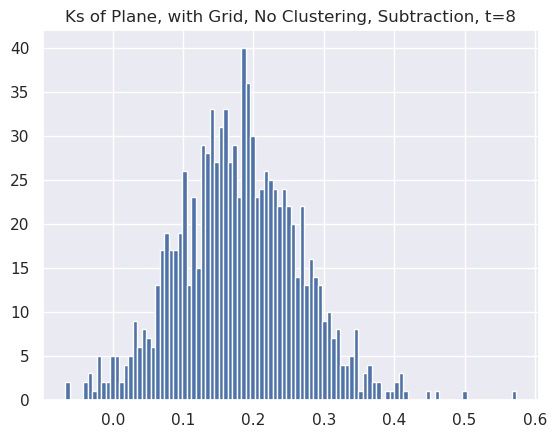

In [ ]:
# plot a histogram of the curvature values
plt.hist(sampled_plane_ks, bins=100)
plt.title(f"Ks of Plane, with Grid, No Clustering, Subtraction, t={t}, knn=15")

In [ ]:
sampled_plane_ks = []
t = 8
for i in trange(1000):
    X_plane = plane(5000,2)
    G = get_alpha_decay_graph(X_plane, decay=None, knn=30, anisotropy=1, )
    DC = DiffusionCurvature(laziness_method="Entropic",points_per_cluster=None,comparison_space_size_factor=1,comparison_method="Subtraction", flattening_method="Fixed", use_grid=True)
    ks = DC.curvature(G, t=t, dim=2, knn=30)
    sampled_plane_ks.append(ks[0])

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Ks of Plane, with Grid, No Clustering, Subtraction, t=8, knn=30')

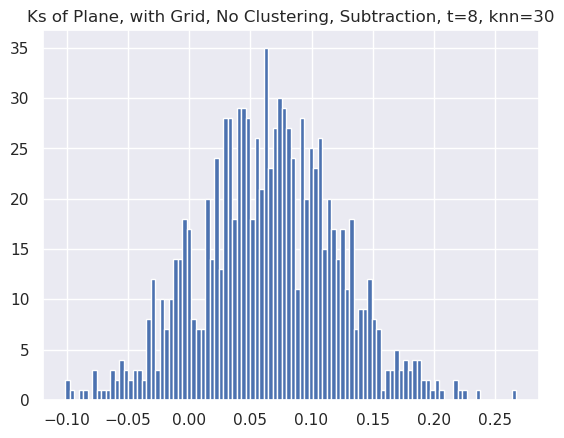

In [ ]:
# plot a histogram of the curvature values
plt.hist(sampled_plane_ks, bins=100)
plt.title(f"Ks of Plane, with Grid, No Clustering, Subtraction, t={t}, knn=30")

The grid, if it can be made to work, greatly reduces the variance in reported curvatures.
To work with it, I see two immediate options:

1. Adopting a non-knn kernel -- something more sophisticated -- that weighs across the distances of all of the k nearest points, and not merely the kth point. If used simultaneously on real data and the comparison space, this would allow us to use the grid. 
2. Instead of changing our kernel to match the hyper-uniform sampling of the grid, whose chief advantage is predictability, we could *average* the results of a large number of uniform samplings. We can take the average entropy over N uniform samplings for a grid of likely pairings between k, t, and d.

I favor the latter approach, as it would also reduce the runtime of the algorithm, by precomputing the expected uniform samplings. If parameters are chosen outside of the precomputed grid, you can revert to a single sampling, as we presently do it.
Additionally, this would allow fast matching of comparison spaces with graphs. At low $t$ values, the diffusion entropy should be approximately equal to the *flat* entropy, modulo the kernel bandwidth, thus allowing us to estimate that $knn$ parameter.

The feasibility question is this: how many pairings do we need?

In [ ]:
num_ks = 30
num_ts = 50
num_ds = 10 # anything much higher dimensional is impossible to get enough samples from
num_trials = num_ks * num_ts * num_ds
num_trials

15000

Each of those could be done in at most 5 minutes, costing

In [ ]:
str(num_trials/12/24)[:4] + " days"

'52.0 days'

Of course, I can parallelize that across Yale's clusters, cutting it down to just a couple of days. That seems feasible.

The other feasibility check is whether the number of points in the comparison space changes the entropy. It shouldn't. Let's check:

In [ ]:
ks_bigs = []
ks_smalls = []
for i in range(100):
    big_plane = plane(5000,2)
    small_plane = plane(500,2)
    DC = DiffusionCurvature(laziness_method="Entropic",points_per_cluster=None,comparison_space_size_factor=1,comparison_method="Subtraction", flattening_method="Fixed", use_grid=False)
    G_big_plane = get_alpha_decay_graph(big_plane, knn=15, anisotropy=1, decay=None)
    G_small_plane = get_alpha_decay_graph(small_plane, knn=15, anisotropy=1, decay=None)
    ks_big = DC.unsigned_curvature(G_big_plane, t=8, idx=0)
    ks_small = DC.unsigned_curvature(G_small_plane, t=8, idx=0)
    ks_bigs.append(ks_big) 
    ks_smalls.append(ks_small)

In [ ]:
# show the mean and standard deviation of ks_bigs and ks_smalls
print("mean of ks_bigs:", np.mean(ks_bigs))
print("mean of ks_smalls:", np.mean(ks_smalls))
print("std of ks_bigs:", np.std(ks_bigs))
print("std of ks_smalls:", np.std(ks_smalls))

mean of ks_bigs: 5.059733
mean of ks_smalls: 5.0795994
std of ks_bigs: 0.07575969
std of ks_smalls: 0.0928274


So there is a difference arising from the number of points used. Likely this is because the diffusion, though concentrated in the center of our plane, has lots of 'close to zero' values that have spread across the manifold.

I tried changing the entropy calculation to zero out elements below an epsilon threshold (set to 10e-5); this helps some, but for large discrepancies in the number of points there's still a .02 discrepancy. Perhaps that's close enough it can be tolerated -- it's certainly less than the variance within different uniform samplings of the plane.

The next step is to modify the 'Fixed' comparison space construction to first load a database of flat entropies (on initialization of the class?), check if the current parameters are within the database, and, if not, average the uniform sampling N times.

## Effects of $t$

In [ ]:
sampled_plane_ks = []
t = 25
for i in trange(1000):
    X_plane = plane(1000,2)
    G = get_alpha_decay_graph(X_plane, decay=None, knn=15, anisotropy=1, )
    DC = DiffusionCurvature(laziness_method="Entropic",points_per_cluster=None,comparison_space_size_factor=1,comparison_method="Subtraction", flattening_method="Fixed", use_grid=True)
    ks = DC.curvature(G, t=t, dim=2, knn=30)
    sampled_plane_ks.append(ks[0])

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Ks of Plane, with Grid, No Clustering, Subtraction, t=25, knn=15')

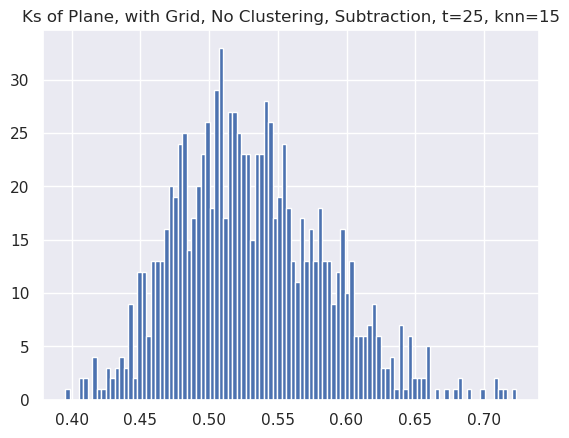

In [ ]:
# plot a histogram of the curvature values
plt.hist(sampled_plane_ks, bins=100)
plt.title(f"Ks of Plane, with Grid, No Clustering, Subtraction, t={t}, knn=15")

In [ ]:
np.std(sampled_plane_ks)

0.054011818

# Samplings of Curved Surfaces

The plane can only tell us so much, since what's all-important is *how much these variances differ* with respect to other curvature values.

To that end, here's the experiment:
1. Randomly construct a number (20-50) of surfaace *equations*, covering a spectum of curvatures.
2. For each surface, randomly sample from it.
3. Measure the the variance in diffusion curvature between samplings in terms of the scalar curvature of samples within that variance.

Repeat the above for:
1. Different densities of samples (non uniformly changing)
2. Noise added to the samplings.

In [ ]:
from diffusion_curvature.random_surfaces import *
from diffusion_curvature.core import DiffusionCurvature
import graphtools

def curved_sampling_experiment(
        num_surfaces = 50, # number of random quadric surfaces, preserved between samplings.
        num_samplings = 100, # number of samplings to perform on each surface
        dim_of_surfaces = 2, # dimension of the surfaces
        density_variance = 0, # variance of densities between samplings.
        num_points_per_surface = 1000, # number of points per surface
        noisiness = 0, # variance of noise added to samples
        t = 25, # diffusion time
):
    random_surfaces = []
    for i in range(num_surfaces):
        F, vars = random_surface(dim_of_surfaces, dim_of_surfaces+1, degree=2)
        random_surfaces.append(F)

    # sample from the surfaces
    sampled_surfaces = [[] for i in range(num_surfaces)]
    real_curvatures = np.empty((num_surfaces, num_samplings))
    for i in trange(num_surfaces, leave=False, desc="Sampling surfaces"):
        for j in range(num_samplings):
            N = int(num_points_per_surface * (1 + np.random.normal(0, density_variance)))
            X = rejection_sample_from_surface(
                    random_surfaces[i], N
                )
            X = X + np.random.normal(0, noisiness, X.shape)
            sampled_surfaces[i].append(X)
            # compute the scalar curvature
            real_curvatures[i][j] = scalar_curvature_at_origin(random_surfaces[i])
            

    # compute the diffusion curvature
    diffusion_curvatures = np.empty((num_surfaces, num_samplings))
    for i in trange(num_surfaces, leave=False, desc="Computing diffusion curvature"):
        for j in range(num_samplings):
            X = sampled_surfaces[i][j]
            G = graphtools.Graph(X, anisotropy=1, knn=15, decay=None).to_pygsp()
            DC = DiffusionCurvature(
                laziness_method="Entropic",
                flattening_method="Mean Fixed",
                comparison_method="Subtraction",
                points_per_cluster=None, # construct separate comparison spaces around each point
                comparison_space_size_factor=1
            )
            diffusion_curvatures[i][j] = DC.curvature(G, t=t, dim=dim_of_surfaces, knn=15, idx=0)
    return diffusion_curvatures, real_curvatures


In [ ]:
def analyze_sampling_results(diffusion_curvatures, real_curvatures, title = "Sampling Results"):
    num_surfaces = diffusion_curvatures.shape[0]
    num_samplings = diffusion_curvatures.shape[1]
    # generate a color for each surface
    colors = np.arange(num_surfaces) / num_surfaces
    # tile the colors, repeating for every sampling
    colors = np.tile(colors, (num_samplings,1)).T
    # flatten the array
    colors = colors.flatten()
    # plot results, as a scatterplot of real curvature vs diffusion curvature, in which each distinct surface has a distinct color.
    plt.figure(figsize=(6,6))
    plt.scatter(real_ks, diffusion_ks, alpha=0.5, c=colors)
    plt.xlabel("Real Curvature")
    plt.ylabel("Diffusion Curvature")
    plt.title(title)
    plt.show()


## Pure Resampling, with no noise, 1000 points

In [ ]:
diffusion_ks, real_ks = curved_sampling_experiment(
    density_variance=0, noisiness=0, num_samplings=5, num_surfaces=50
)

Sampling surfaces:   0%|          | 0/50 [00:00<?, ?it/s]

Computing diffusion curvature:   0%|          | 0/50 [00:00<?, ?it/s]

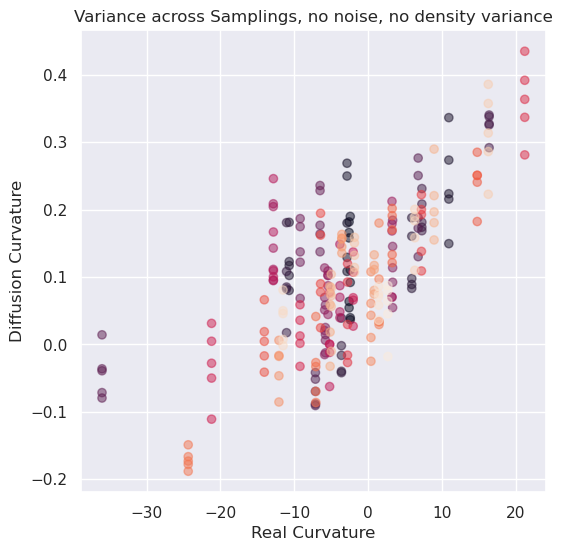

In [ ]:
analyze_sampling_results(diffusion_ks, real_ks, "Variance across Samplings, no noise, no density variance")

## With 0.1 Noise

In [ ]:
diffusion_ks, real_ks = curved_sampling_experiment(
    density_variance=0, noisiness=0.1, num_samplings=5, num_surfaces=50, num_points_per_surface=1000, t = 25, 
)

Sampling surfaces:   0%|          | 0/50 [00:00<?, ?it/s]

Computing diffusion curvature:   0%|          | 0/50 [00:00<?, ?it/s]

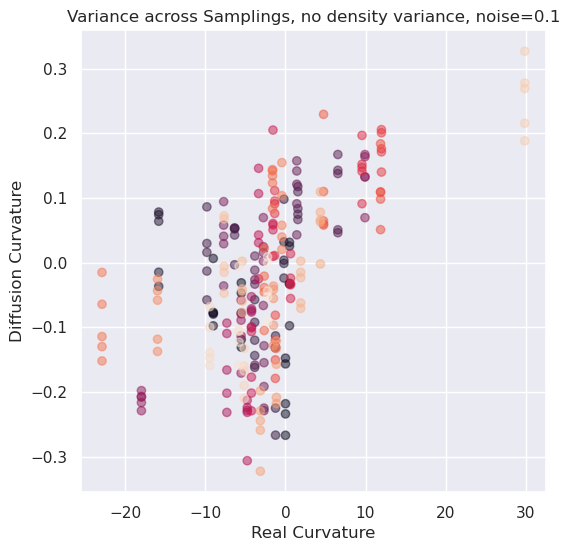

In [ ]:
analyze_sampling_results(diffusion_ks, real_ks, title = "Variance across Samplings, no density variance, noise=0.1")

## With 0.2 Noise

In [ ]:
diffusion_ks, real_ks = curved_sampling_experiment(
    density_variance=0, noisiness=0.2, num_samplings=5, num_surfaces=50, num_points_per_surface=1000, t = 25, 
)

Sampling surfaces:   0%|          | 0/50 [00:00<?, ?it/s]

Computing diffusion curvature:   0%|          | 0/50 [00:00<?, ?it/s]

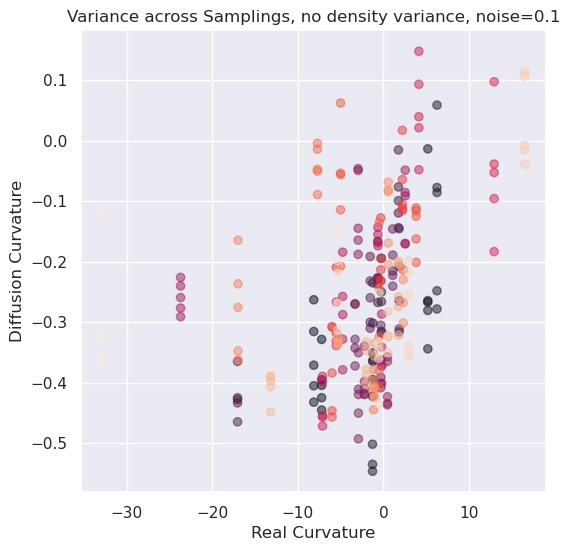

In [ ]:
analyze_sampling_results(diffusion_ks, real_ks, title = "Variance across Samplings, no density variance, noise=0.1")

## With Different Sampling Densities

In [ ]:
diffusion_ks, real_ks = curved_sampling_experiment(
    density_variance=0.1, noisiness=0, num_samplings=5, num_surfaces=50, num_points_per_surface=1000, t = 25, 
)

Sampling surfaces:   0%|          | 0/50 [00:00<?, ?it/s]

Computing diffusion curvature:   0%|          | 0/50 [00:00<?, ?it/s]

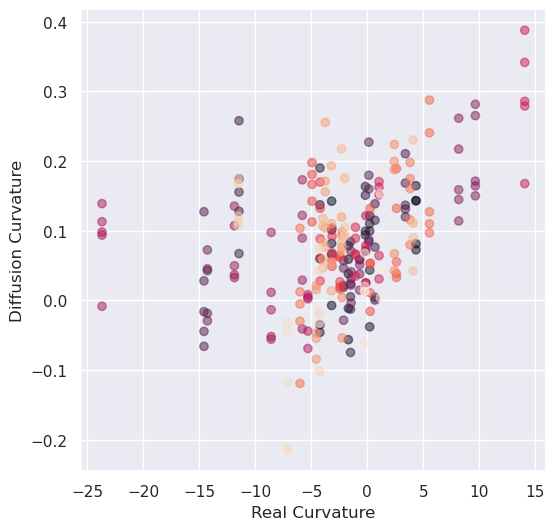

In [ ]:
analyze_sampling_results(diffusion_ks, real_ks, title = "Variance across Samplings, density variance=0.1, no noise")